# Rescale Images based on Projector Greyscale Transfer Function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns; sns.set()
from PIL import Image
from os import listdir

%matplotlib inline

Specify measured screen brightness as a function of the stimulus no. from 1-11. 

In [2]:
Dir = 'screenMeasurements/' #"/Volumes/jayaramanlab/Shivam/" #connect to dm11
rig = "Shivam" #"Shivam"#
reversevals = False

if rig == "Shivam":
    file = rig+"Rig_brightness_level_6.csv"
else:
    reversevals = True
    file = rig+"Rig_brightness.csv"
df = pd.read_csv(Dir+file)

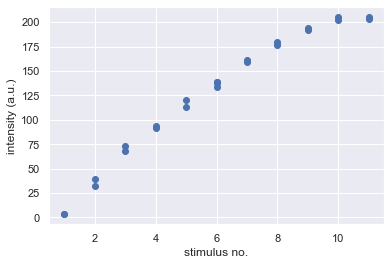

In [3]:
if rig == "Shivam":
    df['Stim'] = 12-df['Stim']
    plt.plot(df['Stim'],df['I'],'o')
    plt.xlabel("stimulus no.")
    plt.ylabel("intensity (a.u.)")
    plt.savefig(Dir+file[:-3],dpi=300)
    
else:
    if reversevals: df['Stim'] = 1-df['Level']
    #if min(df['Level'][0,:]) > 0: df['Level'][0,:] = df['Level'][0,:] - min(df['Level'][0,:])
    #if max(df['Level'][0,:]) >= 10:  df['Level'][0,:] = df['Level'][0,:]/10
    df['I'] = df[df.keys()[1]]
    plt.plot(df['Stim'],df[df.keys()[1]],'o')
    plt.xlabel("stimulus level")
    plt.ylabel("intensity (a.u.)")
    plt.savefig(Dir+file[:-3],dpi=300)

In [4]:
mean_brightness = df.groupby(['Stim']).mean().round(2).reset_index()
mean_brightness['Stim'] = np.linspace(0,255,num=len(mean_brightness['Stim']))
mean_brightness['I'] = 255*(mean_brightness['I']-mean_brightness['I'].min())/(mean_brightness['I'].max()-mean_brightness['I'].min())

In [5]:
mean_brightness

,Stim,I
0,0.0,0.000000
1,25.5,40.757418
2,51.0,84.733860
3,76.5,113.375578
4,102.0,143.474728
5,127.5,169.353660
6,153.0,199.047264
7,178.5,221.605785
8,204.0,240.679141
9,229.5,253.859401


## Calculate Mean Brightness

In [6]:
mean_brightness.to_csv(Dir+'_'.join([file.split('_')[0],'mean']+file.split('_')[1:]))

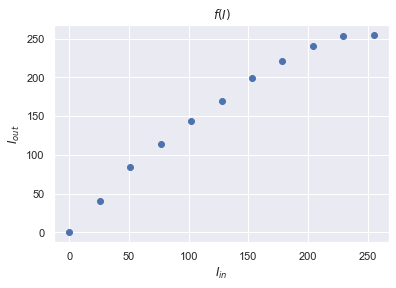

In [7]:
plt.figure()
b = sp.interpolate.interp1d(mean_brightness['Stim'], mean_brightness['I'],bounds_error=False)

plt.plot(mean_brightness['Stim'],mean_brightness['I'],'o');
plt.xlabel("$I_{in}$"); plt.ylabel("$I_{out}$");
plt.title(r'$f(I)$');

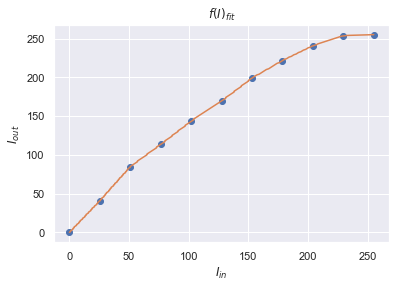

In [8]:
from scipy.optimize import minimize

y = np.array(mean_brightness['I'])
x = np.arange(0,256,1)
y = np.zeros(x.shape)

def diff(x,a):
    yt = b(x)
    return (yt - a)**2

for idx,x_value in enumerate(x):
    res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
    y[idx] = res.x[0]

plt.plot(mean_brightness['Stim'],mean_brightness['I'],'o');
plt.plot(np.round(y).astype('int'),x)
plt.title(r'$f(I)_{fit}$')
plt.ylabel("$I_{out}$"); plt.xlabel("$I_{in}$");
plt.savefig(Dir+'_'.join([file.split('_')[0],'mean']+file.split('_')[1:])[:-4]+"_fit.png",dpi=300)

#### Generate and save lookup table

In [9]:
lookupDf = pd.DataFrame(np.array([np.round(y).astype('int'),x]).T, columns = ["Iin", "Iout"])

In [10]:
lookupDf.to_csv(Dir+rig+"Rig_lookup_table_transformed_brightness.csv")

#### Generate reshaped calibration images

In [11]:
def rescale(img):
    x = img.flatten()
    y = np.array(lookupDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

In [12]:
calibrange = "low"

/Users/haberkernh/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2847: DecompressionBombWarning: Image size (162320000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


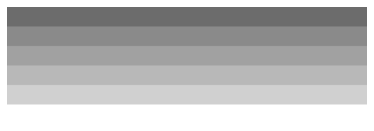

In [13]:
path = 'calibration/originals/'
mg = np.asarray(Image.open(path+'BrightnessSteps_{}.png'.format(calibrange)))
fig = plt.figure(frameon=False)
fig.set_size_inches(5,5)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(rescale(mg), cmap='gray');
plt.savefig(path.replace("originals",
                         "reshaped")+'BrightnessSteps_{}_reshaped_{}Rig.png'.format(calibrange,
                                                                                rig),dpi = 300);

### Confirm Transformed Image is Linear on the Projector Screen

In [14]:
if rig == "Shivam":
        file = rig+"Rig_brightness_level_6_transformed.csv"
else:
    reversevals = True
    file = rig+"Rig_brightness_transformed.csv"
    
dfT = pd.read_csv(Dir+file)

dfT['Stim'] = 12-dfT['Stim']

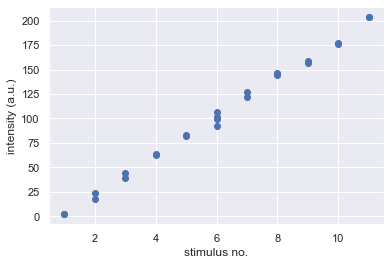

In [15]:
from PIL import Image

for calibrange in ["high","low"]:
    mg = np.asarray(Image.open('calibration/BrightnessSteps_{}.png'.format(calibrange)))
    fig = plt.figure(frameon=False)
    fig.set_size_inches(5,5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(rescale(mg), cmap='gray');
    plt.savefig('calibration/BrightnessSteps_{}_reshaped_{}Rig.png'.format(calibrange,rig),dpi = 300);

#### Generate rescaled skybox images

In [16]:
def greyscale(image):
    grey = np.mean(image[1:],axis=2)
    return grey

In [17]:
savename = '13h'

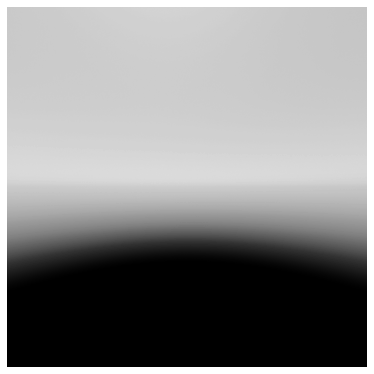

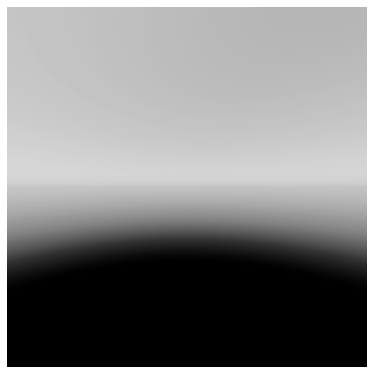

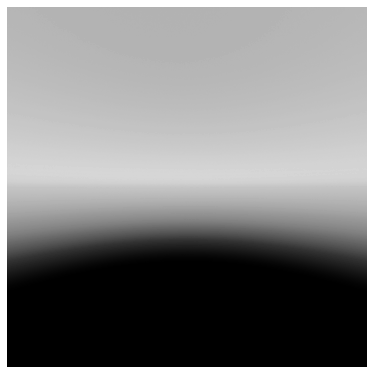

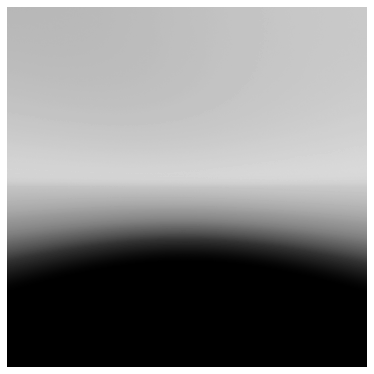

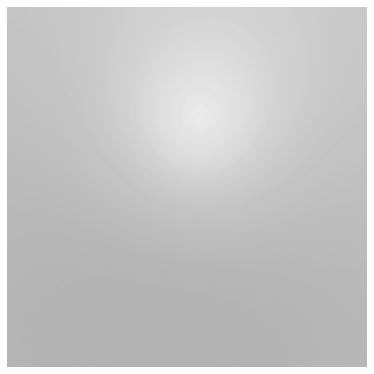

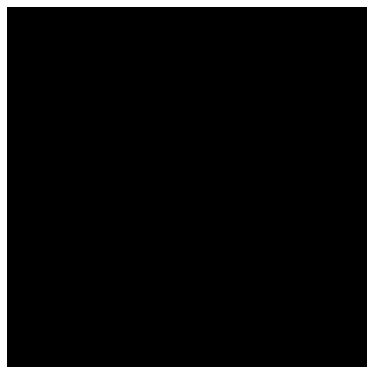

In [18]:
maxBit = 255

root = './skyGradients/originals/'
folder = savename+'/'# 'unity-skybox-16h-el48_52-az250_65/'#'unity-skybox-13h-el68_25-az169_56/'#

path = root + folder

for side, name in enumerate(['Back','Right','Front','Left','Up','Down']):

    grad = np.asarray(Image.open(path + 'SkyBox_{}.png'.format(name)).convert('RGB'))

    fig = plt.figure(frameon=False)
    fig.set_size_inches(5,5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(rescale(greyscale(grad)), cmap='gray', vmin=0, vmax=255)
    fig.savefig(path.replace("originals","reshaped")+"SkyBox_reshaped_{}_{}Rig.png".format(name
                                                                                        ,rig),dpi = dpiVal)

### Reshape Sinusoidal Gradients

In [19]:
path = './panoramas/originals/'

In [20]:
origs = [x for x in listdir(path) if x.endswith('.png')]

In [21]:
dpiVal = 1000

/Users/shivamchitnis/opt/anaconda3/envs/unityvr/lib/python3.8/site-packages/PIL/Image.py:2847: DecompressionBombWarning: Image size (147400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


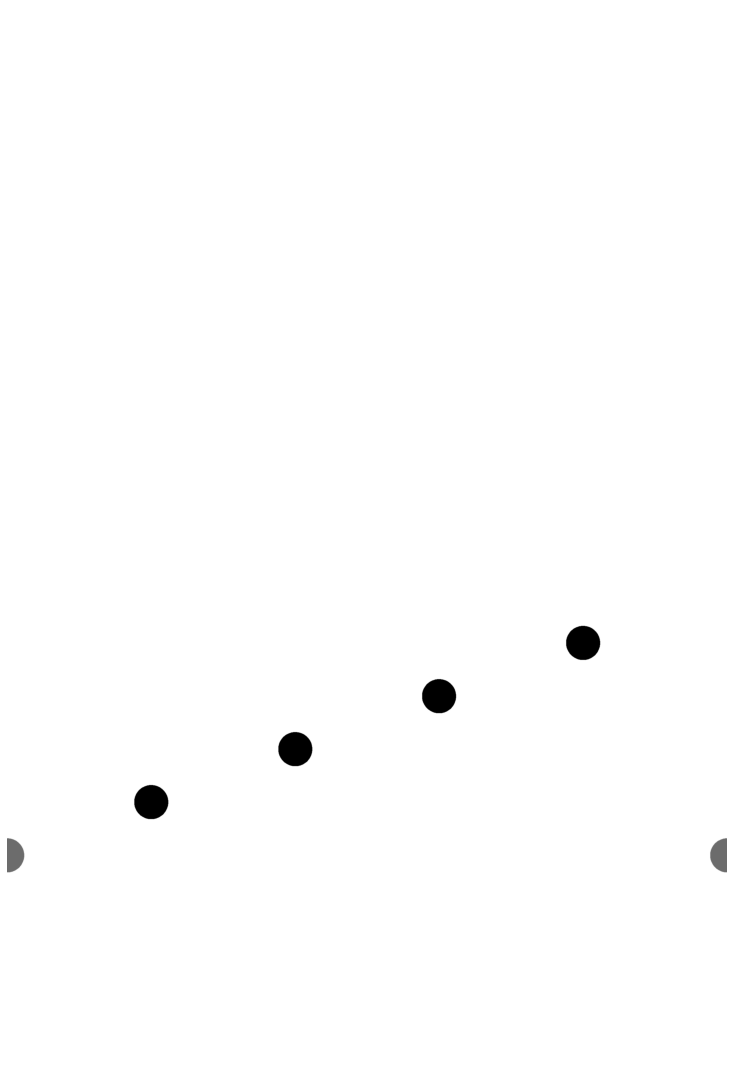

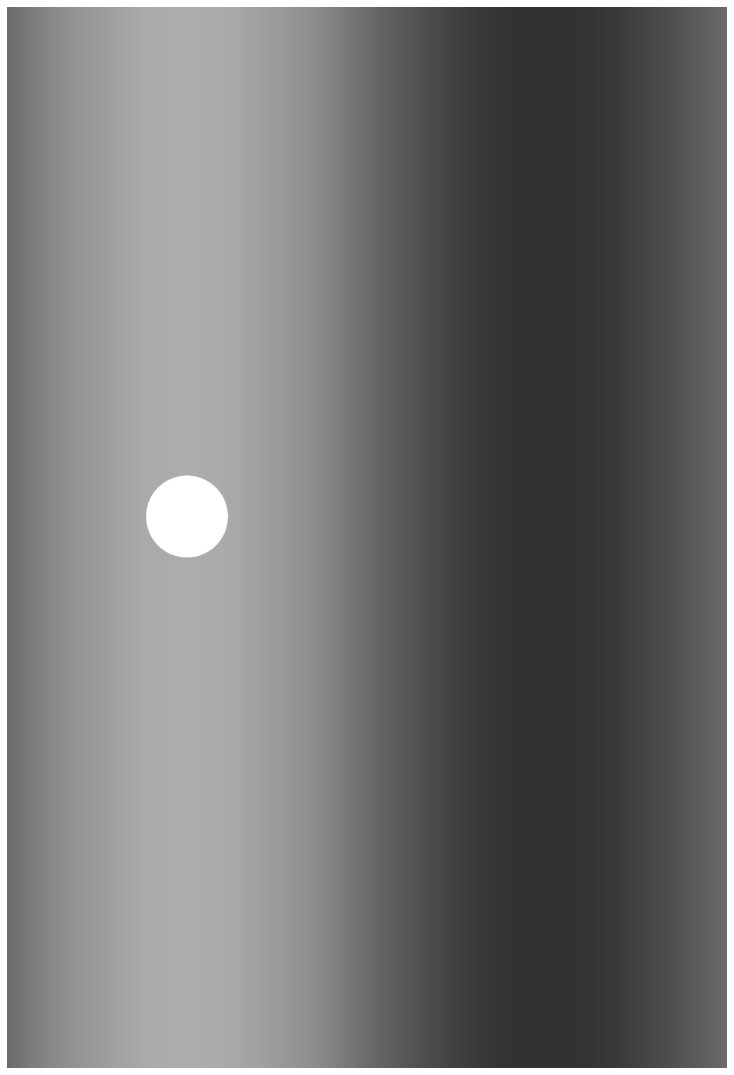

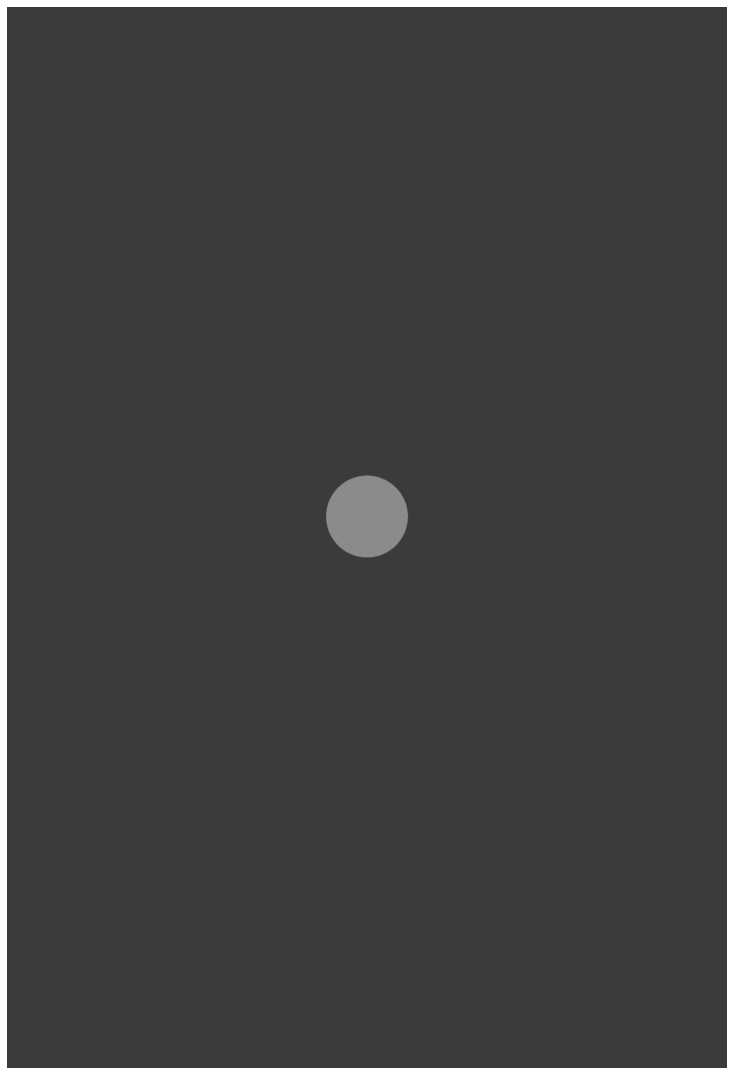

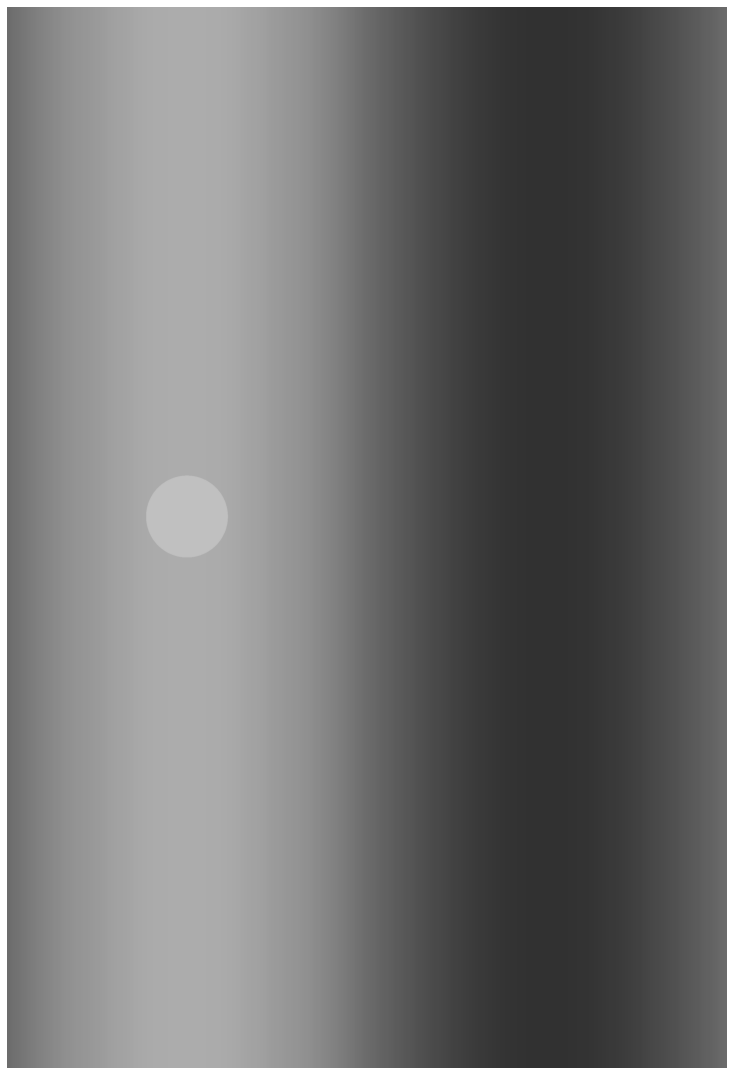

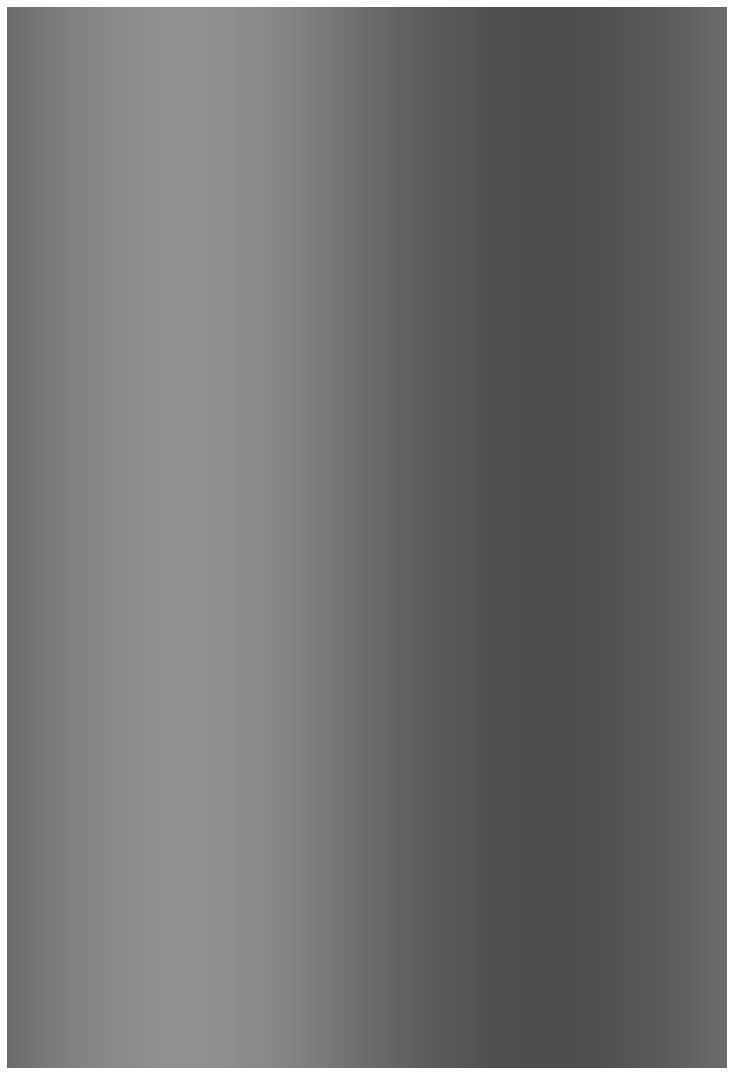

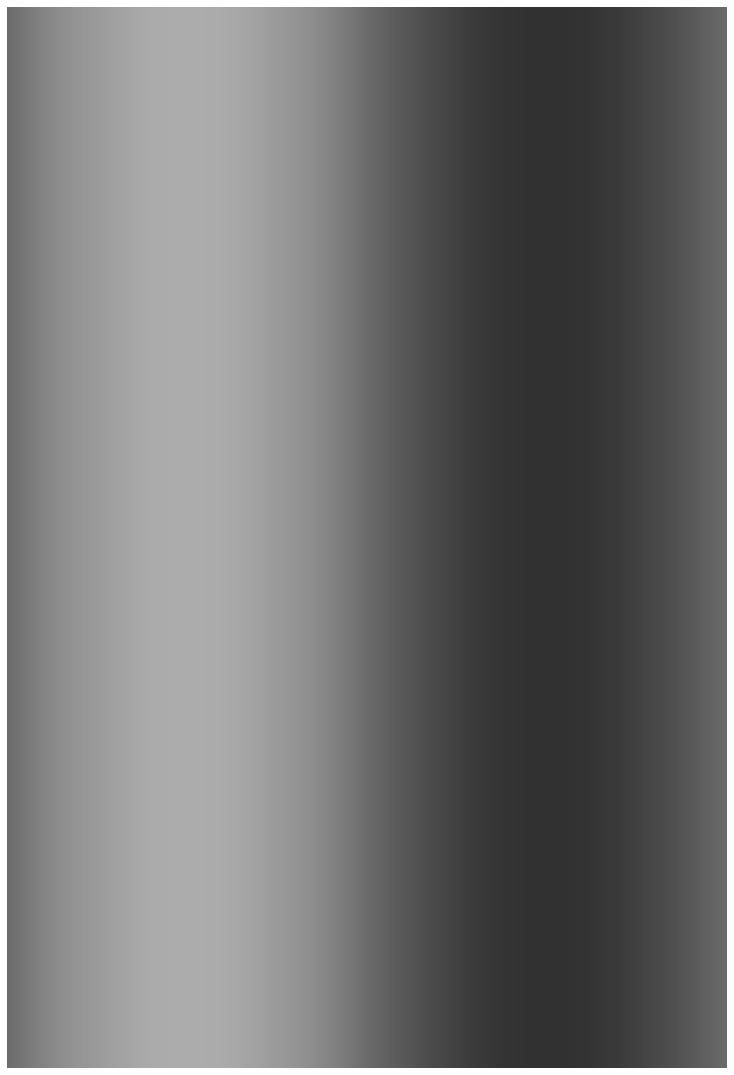

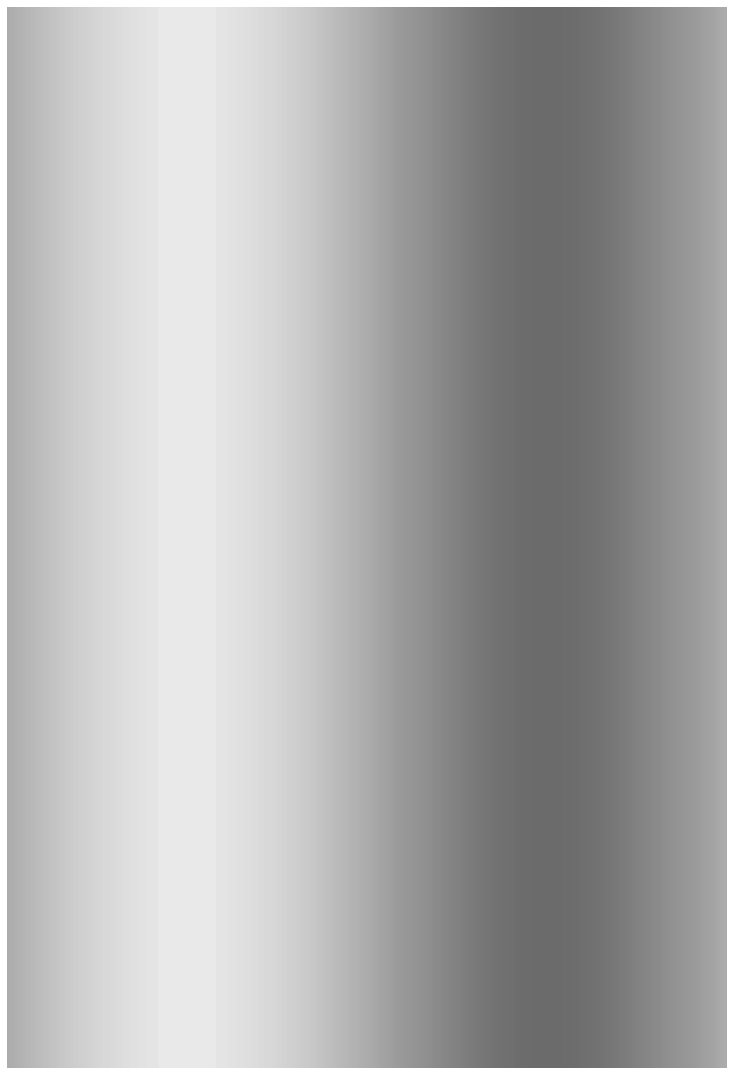

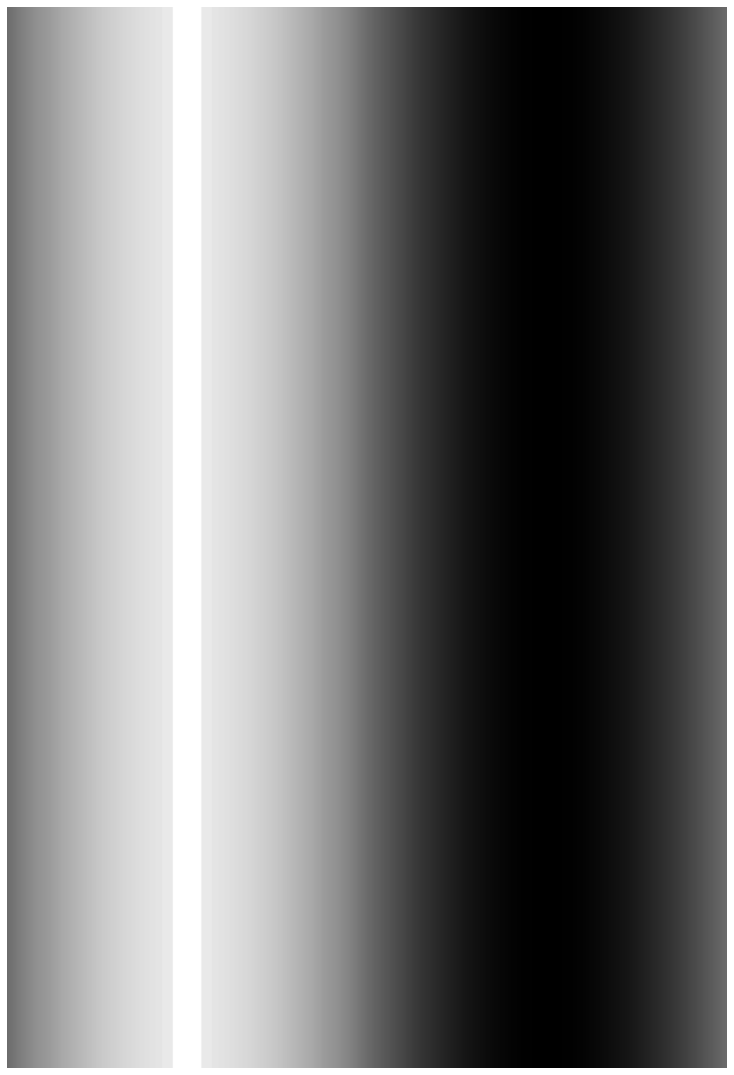

/Users/shivamchitnis/opt/anaconda3/envs/unityvr/lib/python3.8/site-packages/PIL/Image.py:2847: DecompressionBombWarning: Image size (147280000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


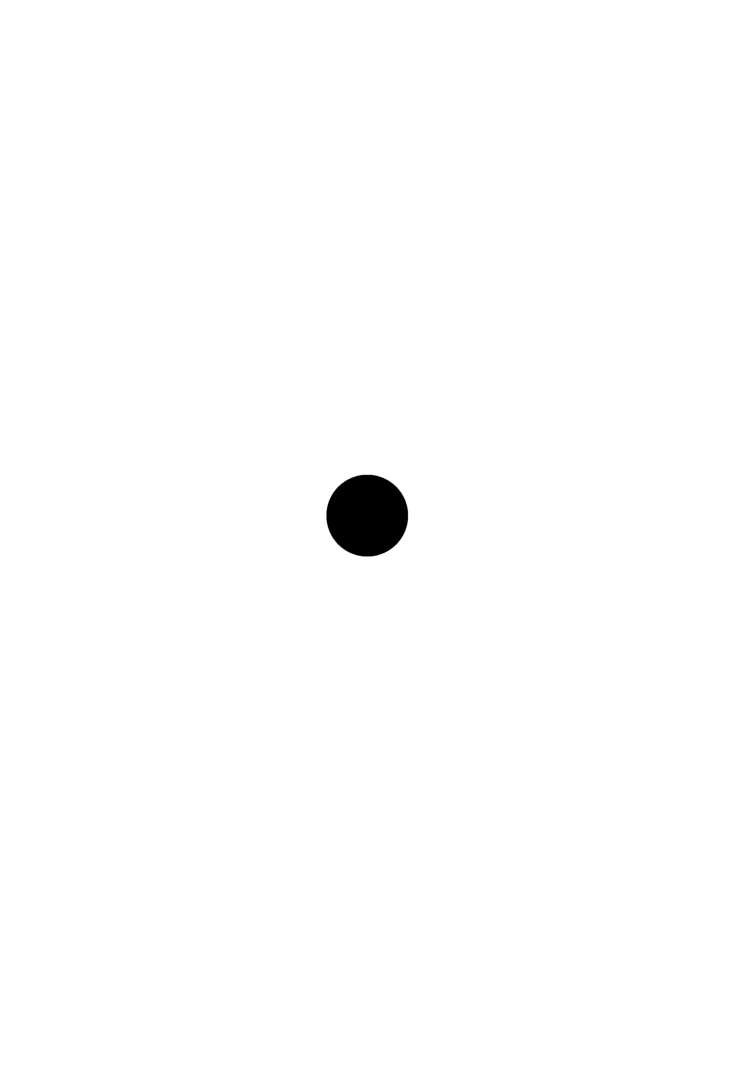

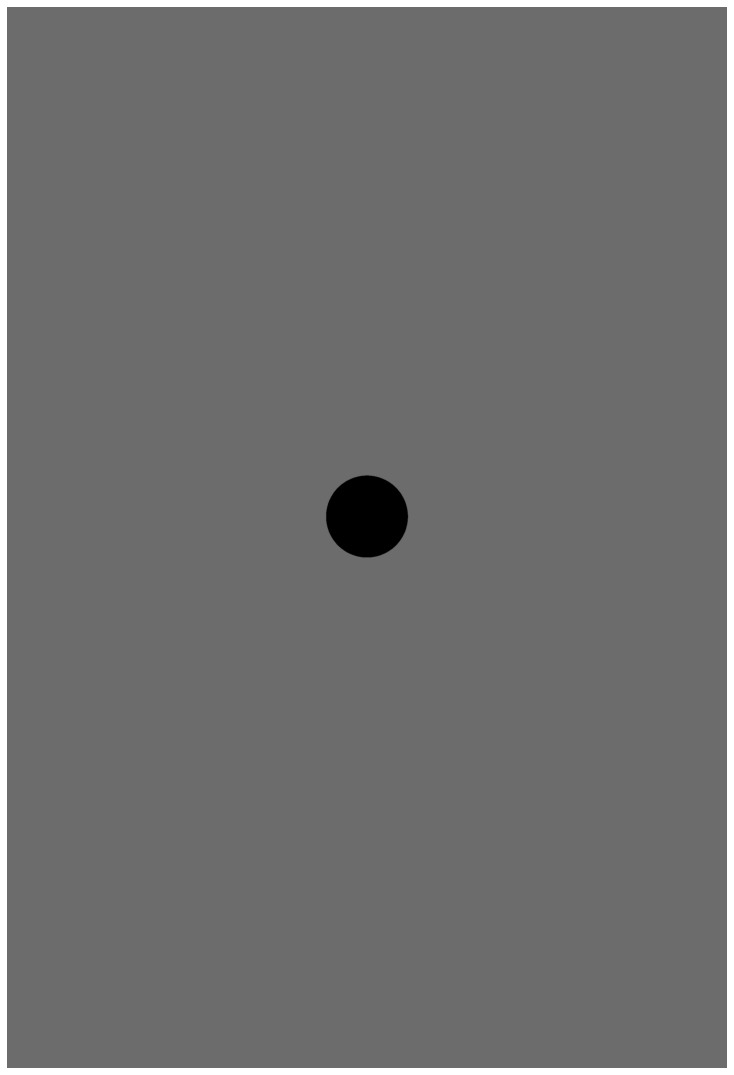

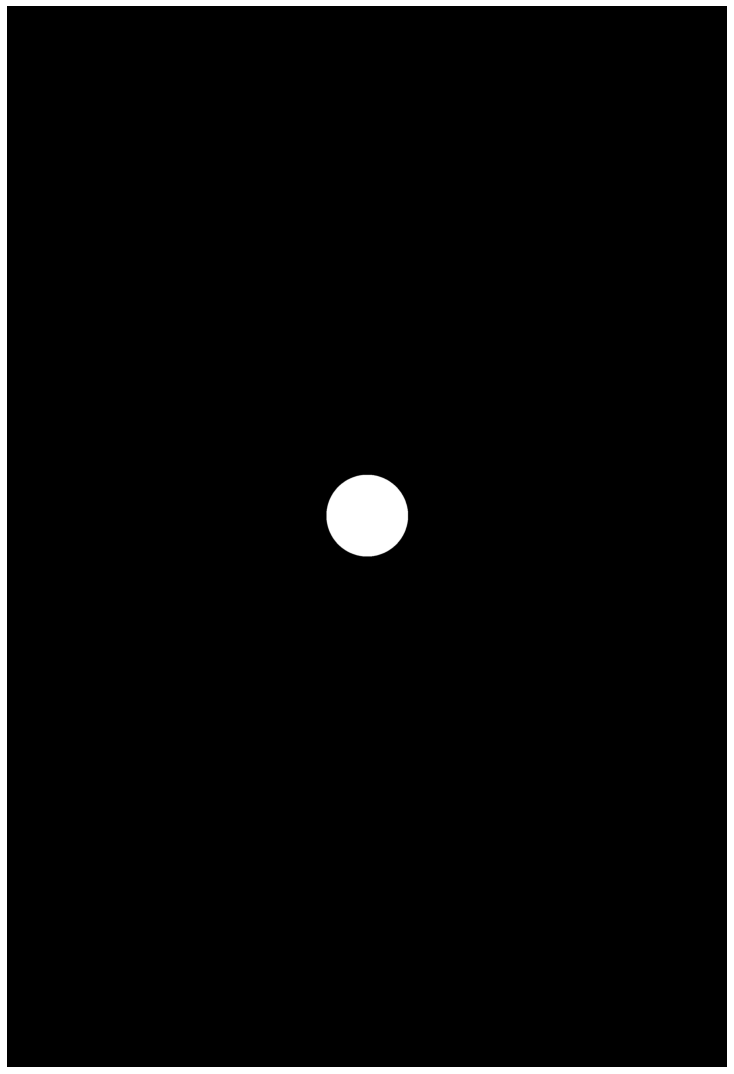

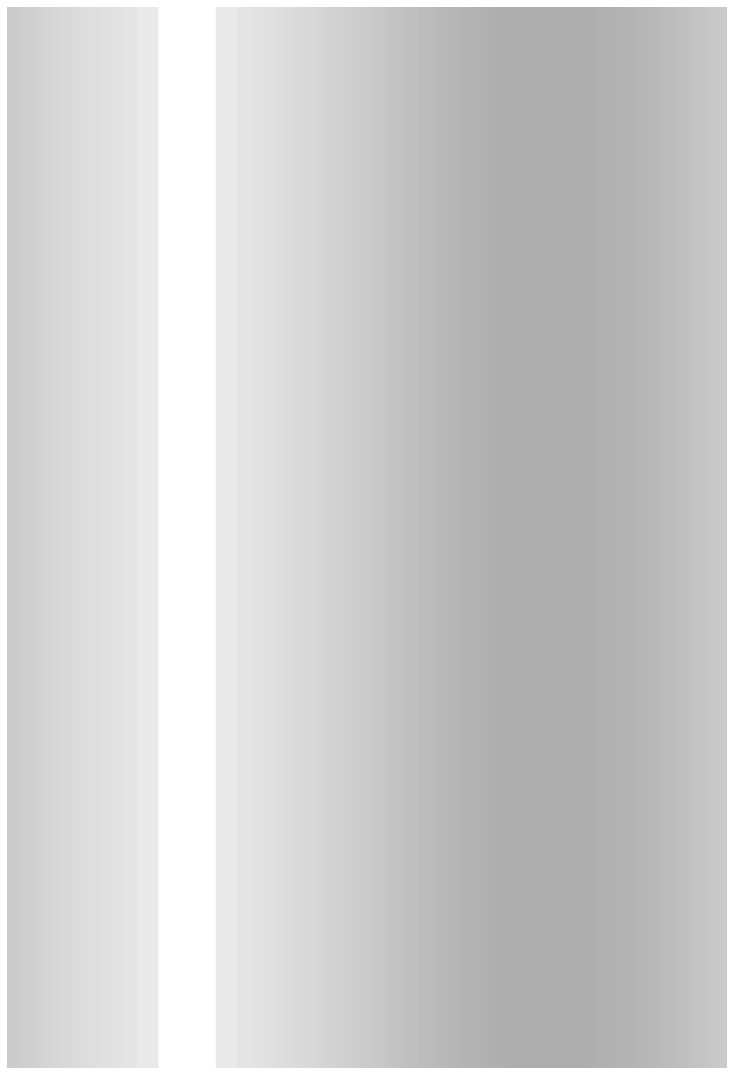

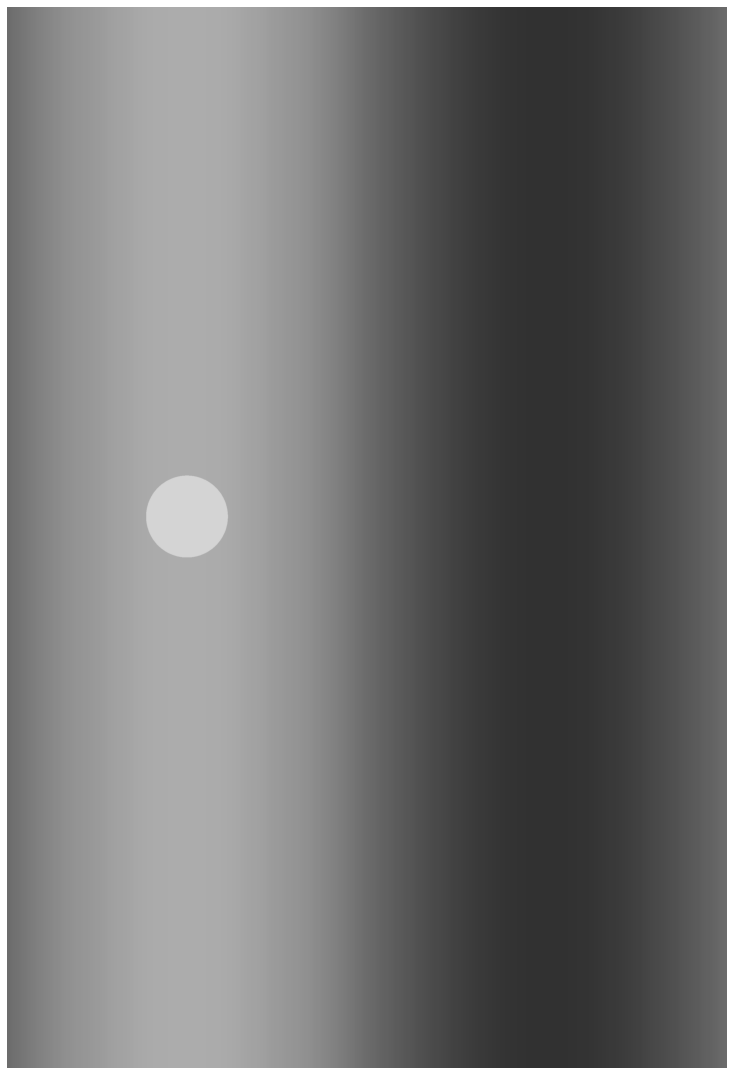

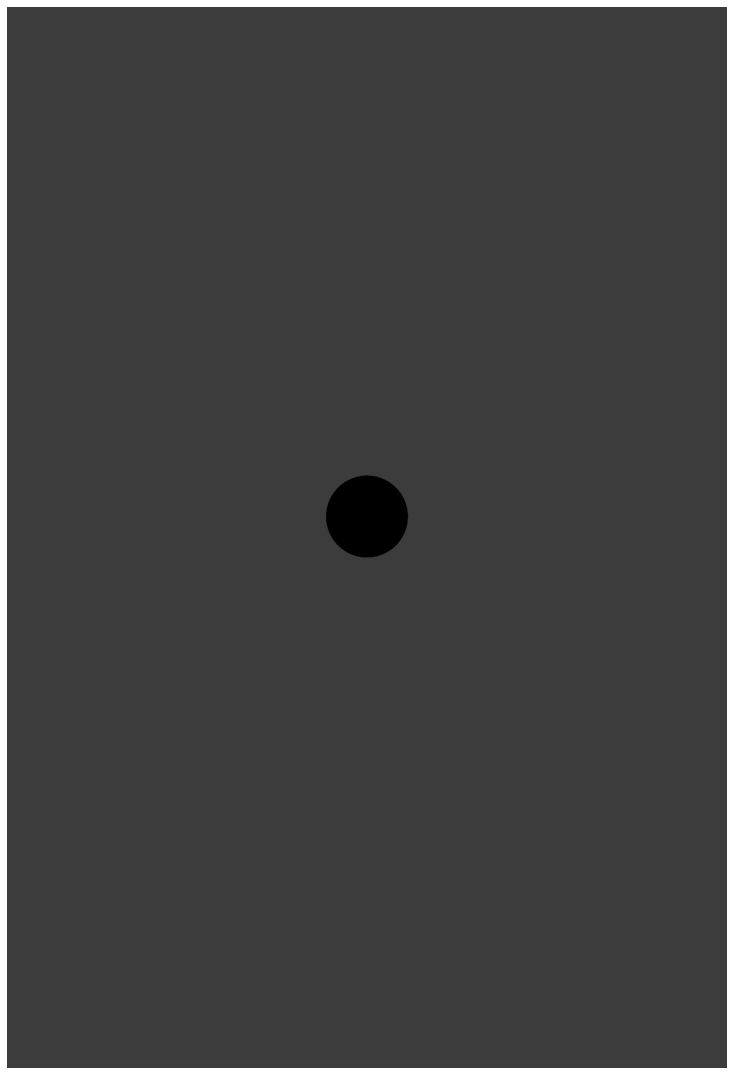

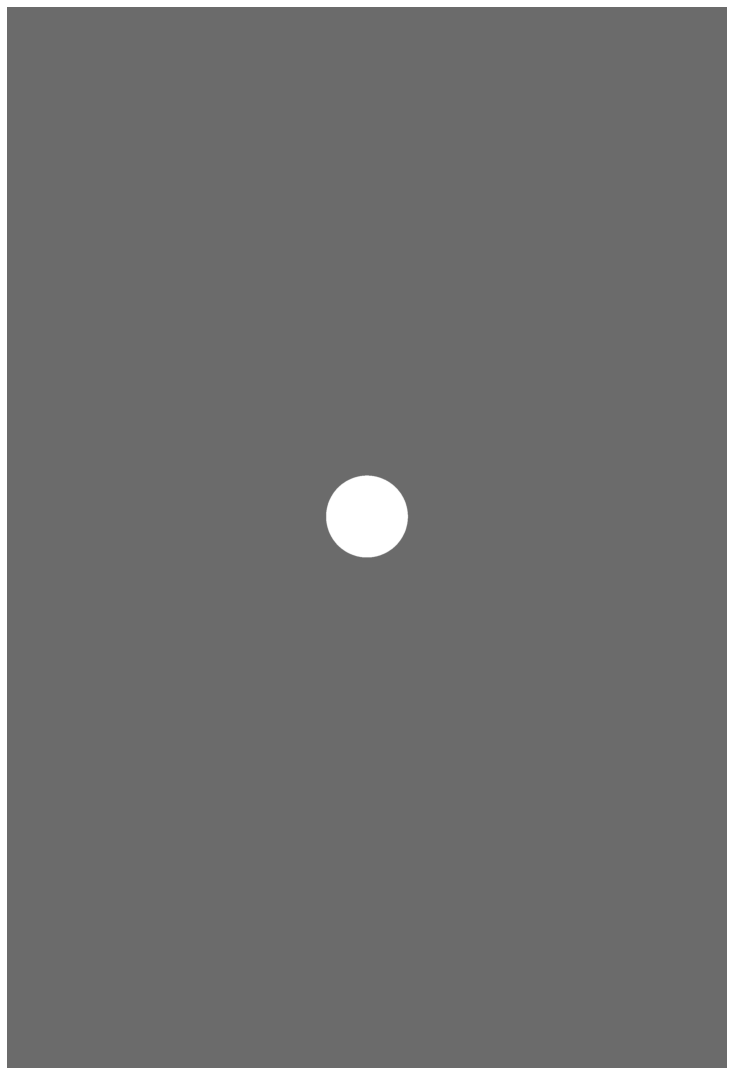

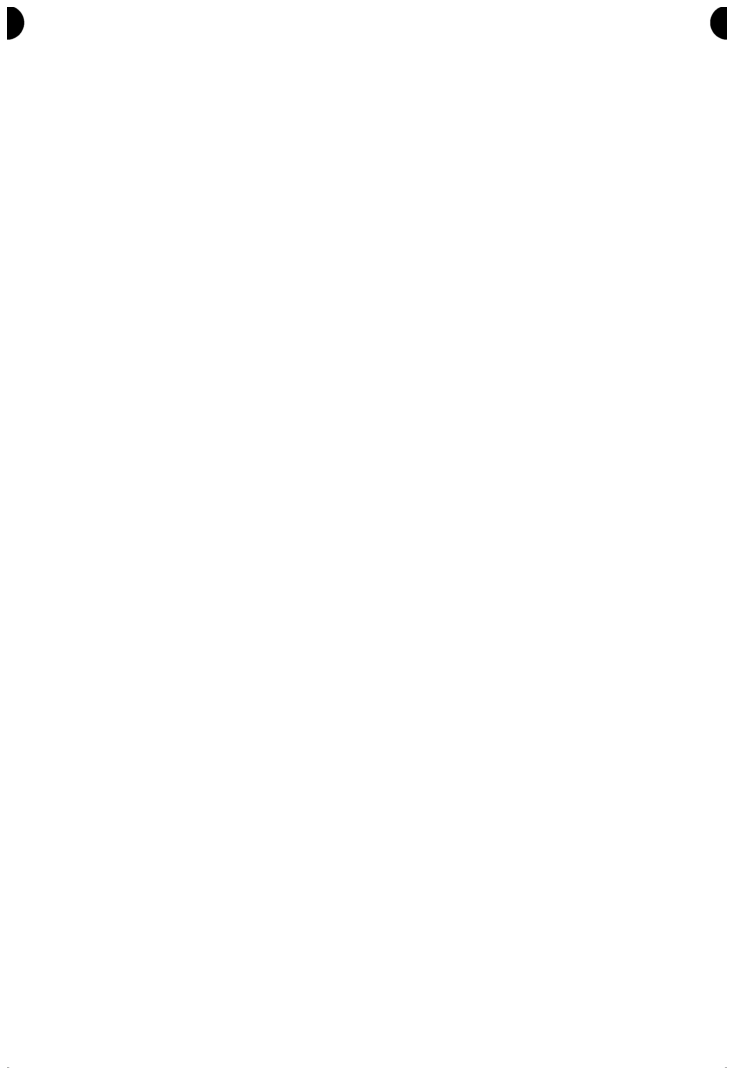

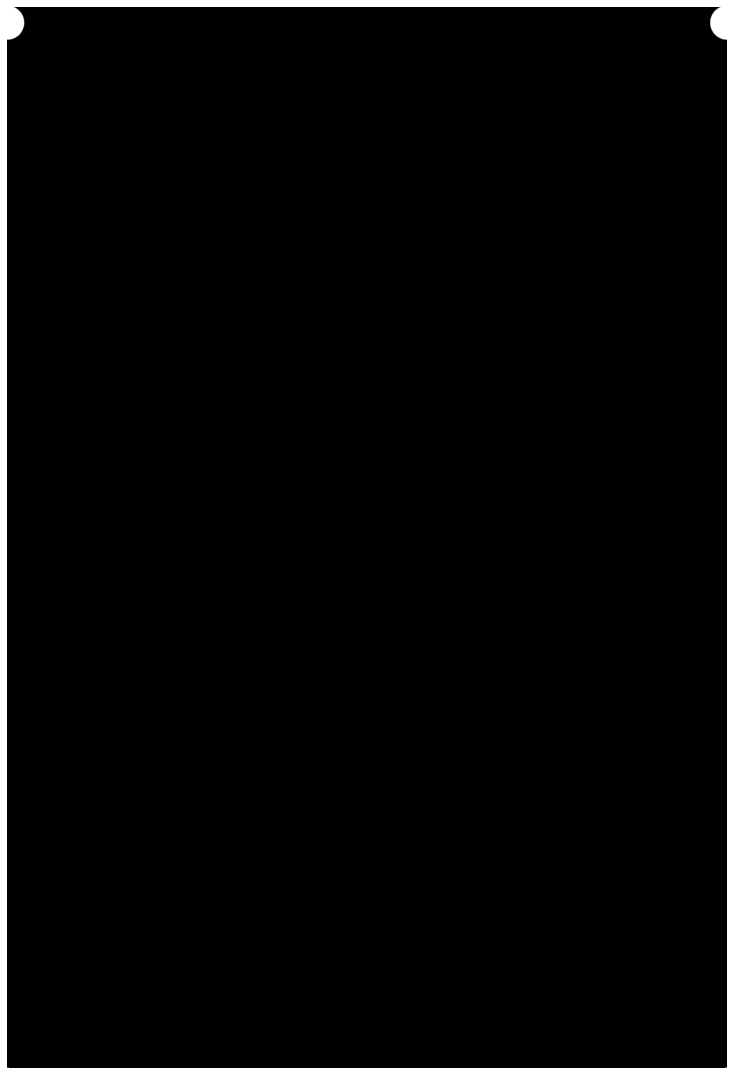

In [22]:
for image in origs:
    
    pan = np.asarray(Image.open(path + image))
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(10,10*np.shape(pan)[0]/np.shape(pan)[1])
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(rescale(pan), cmap='gray', vmin=0, vmax=255)
    fig.savefig(path.replace("originals","reshaped")+image.replace(".png","_reshaped_{}Rig.png").format(rig), dpi=dpiVal)
                
    plt.show()
    plt.close()